#### <span style="color:#grey"> __Formation South Green 2022 - Structural Variants Detection by using short and long reads__ </span>

# <span style="color:#006E7F">  <center> __DAY 2 : How to analyze mapping results ?__ </center> </span>

Created by C. Tranchant (DIADE-IRD), J. Orjuela (DIADE-IRD), F. Sabot (DIADE-IRD) and A. Dereeper (PHIM-IRD)

***

# <span style="color: #006E7F">Table of contents</span>
<a class="anchor" id="home"></a>

[I - Get some basic mapping stats with samtools flagstat](#mappingstats)

* [Run samtools flagstat](#flagstat)
* [Samtools flagstat output](#flagstatoutput)
* [Merge individual flagstat files into an unique file with python code](#multiflagstat) 
* [Plot mapping ratio per sample](#ratioplot)
* [EXERCICE : DO THE SAME MANIP WITH MINIMAP2 RESULTS](#minimap)

[II - Get some basic stats from vcf files](#statvcf) 
* [Count the number of variants with `bcftools stat`](#bcftools)
* [Generating statistics from a VCF to determining how to set filters on it](#vcffilters)
* [Generating density plot QUAL & DEPTH](#vcfplot) 

[III - FILTERING VCF](#vcffiltering)

</span>

***



## <span style="color:#006E7F">__I - Get some basic mapping stats with samtools flagstat__ <a class="anchor" id="mappingstats"></span>  

### <span style="color: #4CACBC;"> First go into the directory that contains all the bam files</span>  


In [217]:
%cd /home/jovyan/work/MAPPING-ILL/BAM
%ls

/home/jovyan/work/MAPPING-ILL/BAM
all_stat.csv            Clone2.bam.stat        Clone5.SORTED.bam
Clone10.bam             Clone2.SORTED.bam      Clone5.SORTED.bam.bai
Clone10.bam.flagstat    Clone2.SORTED.bam.bai  Clone6.SORTED.bam
Clone10.bam.stat        Clone3.bam             Clone6.SORTED.bam.bai
Clone10.SORTED.bam      Clone3.bam.flagstat    Clone7.SORTED.bam
Clone10.SORTED.bam.bai  Clone3.bam.stat        Clone7.SORTED.bam.bai
Clone1.SORTED.bam       Clone3.SORTED.bam      Clone8.SORTED.bam
Clone1.SORTED.bam.bai   Clone3.SORTED.bam.bai  Clone8.SORTED.bam.bai
Clone2.bam              Clone4.SORTED.bam      Clone9.SORTED.bam
Clone2.bam.flagstat     Clone4.SORTED.bam.bai  Clone9.SORTED.bam.bai


### <span style="color: #4CACBC;">Run samtools flagstat on each bam file (generated by bwa-mem2) - `for loop`<a class="anchor" id="flagstat"></span> 
Save the flagstat output into a file - ex : Clone2.bam -> Clone2.bam.flagstat

In [5]:
%%bash

for file in *bam;
do
    echo $file
    samtools flagstat $file > $file.flagstat
done;
ls  *flagstat 

Clone10.bam
Clone2.bam
Clone3.bam
Clone10.bam.flagstat
Clone2.bam.flagstat
Clone3.bam.flagstat


### <span style="color: #4CACBC;">Let's look the content of one file <a class="anchor" id="flagstatoutput"></span> 

In [218]:
cat Clone2*stat

266640 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 duplicates
266640 + 0 mapped (100.00%:-nan%)
266640 + 0 paired in sequencing
133320 + 0 read1
133320 + 0 read2
266640 + 0 properly paired (100.00%:-nan%)
266640 + 0 with itself and mate mapped
0 + 0 singletons (0.00%:-nan%)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)
266640 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 duplicates
266640 + 0 mapped (100.00%:-nan%)
266640 + 0 paired in sequencing
133320 + 0 read1
133320 + 0 read2
266640 + 0 properly paired (100.00%:-nan%)
266640 + 0 with itself and mate mapped
0 + 0 singletons (0.00%:-nan%)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


### <span style="color: #4CACBC;">Merge individual flagstat files into an unique file with python code <a class="anchor" id="multiflagstat"></span> 

In [71]:
# IMPORT PYTHON PACKAGE USED BY THE CODE
import os
import pandas as pd




# VARIABLE INITIALIZATION

## NAME OF THE DIRECTORY THAT CONTAINS FLAGSTAT FILES
flagstat_dir = "/home/jovyan/work/MAPPING-ILL/BAM/" #PUT THE DIRECTORY NAME THAT CONTAINS FLAGSTAT FILES 

## NAME OF THE FILE THAT WILL CONTAIN ALL THE FLAGSTAT RESULTATS
stat_file = flagstat_dir + "all_stat.csv"


# PRINT THE CONTENT OF 2 PREVIOUS VARIABLES INITIALIZED
print("DIRECTORY : ",flagstat_dir)
print("FINAL STAT FILE : ",stat_file)



In [78]:
# OPEN THE FINAL FILE IN WHICH WE PRINT SOME STATS EXTRACTED FROM EACH INDIVIDUAL FILE GENERATED BY SAMTOOLS FLAGSTAT
stat = open(stat_file, "w")

# WRITE A HEADER LINE IN OUR STAT FILE
header_line = "sample,mapped,paired, unmapped"
stat.write(header_line)

# READING EACH FILE OF THE FLGSTAT DIRECTORY
for file in os.listdir(flagstat_dir):
    #print("\n>>>>>>>> file: ",file)
    
    if "flagstat" in file:
        #print("Reading only flagstat file :",file)
        
        # Extract sample name and save into a new variable newLine 
        sample_name = file.split('.')[0]
        #print(f"Sample : {sample_name}")
        newLine = f"\n {sample_name},"
        
        # Read individual flagstat file
        ## OPEN THE FILE
        with open(file, "r") as flagstat:
            # READ THE FILE LINE BY LINE
            for line in flagstat:
                # REMOVE THE LINE SKIPPER AT THE END OF THE LINE
                line = line.rstrip()
                #print(f">>>>>>>>>> LINE : {line}")
                
                # Keep only line mapped, paired or singleton word
                if 'mapped (' in line or 'paired (' in line or 'singleton' in line:
                    # get percentage value and save it into the varaible called perc
                    perc = f"{line.split('(')[1].split('%')[0]}"
                    newLine += f"{perc},"
            
            flagstat.close()   
            # WRITE THE LINE ONCE THE FLAGSTAT FILE COMPLETELY READ
            stat.write(newLine)

stat.close()

### <span style="color: #4CACBC;">Display the content of the final stat file  <a class="anchor" id="statfile"></span> 

In [79]:
%cat $stat_file

sample,mapped,paired, unmapped
 Clone2,100.00,100.00,0.00,
 Clone10,74.74,73.71,0.55,
 Clone3,100.00,100.00,0.00,

### <span style="color: #4CACBC;">Plot mapping ratio per sample <a class="anchor" id="ratioplot"></a></span> 

#### Load csv file into a panda datafrale


In [82]:
df_bam_stat = pd.read_csv(stat_file, index_col=False)
df_bam_stat

,sample,mapped,paired,unmapped
0,Clone2,100.00,100.00,0.00
1,Clone10,74.74,73.71,0.55
2,Clone3,100.00,100.00,0.00


#### Basic stats

In [99]:
# Je n'affiche que les valeurs de la colonne "mapped"
print(df_bam_stat["mapped"])

0    100.00
1     74.74
2    100.00
Name: mapped, dtype: float64


In [96]:
# J affiche la moyenne, min et max de cette colonne
print("\n######## BASIC STATS\n MAPPED")
print("## % min - max :", df_bam_stat["mapped"].min(), "-", df_bam_stat["mapped"].max())
print("## % mean :", df_bam_stat["mapped"].mean())



######## BASIC STATS
 MAPPED
## % min - max : 74.74 - 100.0
## % mean : 91.58


<AxesSubplot:xlabel='sample', ylabel='paired'>

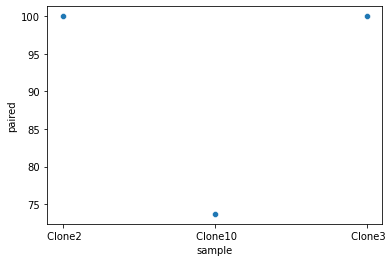

In [100]:
# Plot with seaborn
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x="sample",y="paired", data=df_bam_stat)

Text(0.5, 0, 'PUT YOUR Y AXIS')

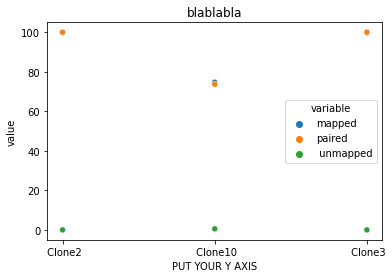

In [110]:
# Plot with seaborn
import matplotlib.pyplot as plt
import seaborn as sns

ax=sns.scatterplot(x="sample",y="value", hue='variable', data=pd.melt(df_bam_stat, 'sample'))
ax.set_title("blablabla")
ax.set_xlabel("PUT YOUR X AXIS")
ax.set_xlabel("PUT YOUR Y AXIS")

### <span style="color: #4CACBC;"> EXERCICE : DO THE SAME THING WITH MINIMAP2 RESULTS <a class="anchor" id="minimap"></span> 

## <span style="color:#006E7F">__II. Get some basic stats from vcf files__ <a class="anchor" id="statvcf"></a></span> 

### <span style="color: #4CACBC;">First go into the directory that contains vcf file  </span> 

In [221]:
%cd /home/jovyan/work/MAPPING-ILL/VCF/
%ls -lrt

/home/jovyan/work/MAPPING-ILL/VCF
total 48924
-rw-r--r-- 1 jovyan users  1678691 Jun 16 11:52 out.vcf.gz
-rw-r--r-- 1 jovyan users    22402 Jun 16 19:38 Clone1.g.vcf.idx
-rw-r--r-- 1 jovyan users  8267523 Jun 16 19:38 Clone1.g.vcf
-rw-r--r-- 1 jovyan users 10812528 Jun 16 19:51 Clone2.g.vcf
-rw-r--r-- 1 jovyan users    26799 Jun 16 19:51 Clone2.g.vcf.idx
-rw-r--r-- 1 jovyan users 21611979 Jun 16 19:52 final.vcf
-rw-r--r-- 1 jovyan users    46372 Jun 16 19:52 final.vcf.idx
-rw-r--r-- 1 jovyan users  5896437 Jun 16 19:56 final.genotype.vcf
-rw-r--r-- 1 jovyan users     4301 Jun 16 19:56 final.genotype.vcf.idx
-rw-r--r-- 1 jovyan users    13695 Jun 16 20:31 final.genotype.stats
-rw-r--r-- 1 jovyan users   898238 Jun 16 20:46 AF.frq
-rw-r--r-- 1 jovyan users   788885 Jun 16 20:46 AF2.frq
-rw-r--r-- 1 jovyan users       66 Jun 16 21:27 depthi.idepth


### <span style="color: #4CACBC;">Count the number of variants with `bcftools stat`<a class="anchor" id="bcftools"></a></span> 

In [ ]:
%%bash
bcftools stats final.genotype.vcf >  final.genotype.stats

In [222]:
%%bash
head -n 35 final.genotype.stats

# This file was produced by bcftools stats (1.10.2+htslib-1.10.2-3) and can be plotted using plot-vcfstats.
# The command line was:	bcftools stats  final.genotype.vcf
#
# Definition of sets:
# ID	[2]id	[3]tab-separated file names
ID	0	final.genotype.vcf
# SN, Summary numbers:
#   number of records   .. number of data rows in the VCF
#   number of no-ALTs   .. reference-only sites, ALT is either "." or identical to REF
#   number of SNPs      .. number of rows with a SNP
#   number of MNPs      .. number of rows with a MNP, such as CC>TT
#   number of indels    .. number of rows with an indel
#   number of others    .. number of rows with other type, for example a symbolic allele or
#                          a complex substitution, such as ACT>TCGA
#   number of multiallelic sites     .. number of rows with multiple alternate alleles
#   number of multiallelic SNP sites .. number of rows with multiple alternate alleles, all SNPs
# 
#   Note that rows containing multiple types will be c

### <span style="color: #4CACBC;">Generating statistics from a VCF to determine how to set filters on it<a class="anchor" id="vcffilters"></a></span> 

We will generate more statistics from a VCF using vcftools (LINK MANUAL), a very useful and fast program for handling vcf files 
to easily calculate these statistics in order to better define filters we will apply and to get an idea of how to set such filtering thresholds. 

The main information we will consider are:
* Depth: Usually, we filter SNP with a minimum and maximum depth. We use a minimum depth cutoffs to remove false positive calls and to keep higher quality calls too. 
A maximum cut off allow to remove regions with very, very high read depths such as repetitive regions.
* Quality Genotype quality : With this filter, we should not trust any genotype with a Phred score below 20 which suggests a less than 99% accuracy.
* Minor allele frequency MAF can cause big problems with SNP calls - and also inflate statistical estimates downstream. Ideally you want an idea of the distribution of your 
allelic frequencies but 0.05 to 0.10 is a reasonable cut-off. You should keep in mind however that some analyses, particularly demographic inference can be biased by MAF thresholds.
* Missing data How much missing data are you willing to tolerate? It will depend on the study but typically any site with >25% missing data should be dropped.
* biallelic, heterozygosity...

In this training, we will just display quality and depth distribution... but you should do on each value filterd.

#### <span style="color: #4CACBC;">Mean depth per infividual and per site<a class="anchor" id="depthvcf"></a></span> 



In [ ]:
%%bash
vcftools --gzvcf  final.genotype.vcf --depth --out depthi
vcftools --gzvcf  final.genotype.vcf --site-mean-depth --out depths

In [227]:
%%bash
ls -lrt
head *depth*

total 50252
-rw-r--r-- 1 jovyan users  1678691 Jun 16 11:52 out.vcf.gz
-rw-r--r-- 1 jovyan users    22402 Jun 16 19:38 Clone1.g.vcf.idx
-rw-r--r-- 1 jovyan users  8267523 Jun 16 19:38 Clone1.g.vcf
-rw-r--r-- 1 jovyan users 10812528 Jun 16 19:51 Clone2.g.vcf
-rw-r--r-- 1 jovyan users    26799 Jun 16 19:51 Clone2.g.vcf.idx
-rw-r--r-- 1 jovyan users 21611979 Jun 16 19:52 final.vcf
-rw-r--r-- 1 jovyan users    46372 Jun 16 19:52 final.vcf.idx
-rw-r--r-- 1 jovyan users  5896437 Jun 16 19:56 final.genotype.vcf
-rw-r--r-- 1 jovyan users     4301 Jun 16 19:56 final.genotype.vcf.idx
-rw-r--r-- 1 jovyan users    13695 Jun 16 20:31 final.genotype.stats
-rw-r--r-- 1 jovyan users   898238 Jun 16 20:46 AF.frq
-rw-r--r-- 1 jovyan users   788885 Jun 16 20:46 AF2.frq
-rw-r--r-- 1 jovyan users       66 Jun 17 07:18 depthi.idepth
-rw-r--r-- 1 jovyan users   674196 Jun 17 07:18 depths.ldepth.mean
-rw-r--r-- 1 jovyan users   682434 Jun 17 07:19 qual.lqual
==> depthi.idepth <==
INDV	N_SITES	MEAN_DEPTH
Clone

#### <span style="color: #4CACBC;">Extracting quality per site<a class="anchor" id="depthvcf"></a></span> 


In [ ]:
%%bash
vcftools --gzvcf final.genotype.vcf  --site-quality --out qual

In [229]:
%%bash
ls -lrt
head *qual

total 50252
-rw-r--r-- 1 jovyan users  1678691 Jun 16 11:52 out.vcf.gz
-rw-r--r-- 1 jovyan users    22402 Jun 16 19:38 Clone1.g.vcf.idx
-rw-r--r-- 1 jovyan users  8267523 Jun 16 19:38 Clone1.g.vcf
-rw-r--r-- 1 jovyan users 10812528 Jun 16 19:51 Clone2.g.vcf
-rw-r--r-- 1 jovyan users    26799 Jun 16 19:51 Clone2.g.vcf.idx
-rw-r--r-- 1 jovyan users 21611979 Jun 16 19:52 final.vcf
-rw-r--r-- 1 jovyan users    46372 Jun 16 19:52 final.vcf.idx
-rw-r--r-- 1 jovyan users  5896437 Jun 16 19:56 final.genotype.vcf
-rw-r--r-- 1 jovyan users     4301 Jun 16 19:56 final.genotype.vcf.idx
-rw-r--r-- 1 jovyan users    13695 Jun 16 20:31 final.genotype.stats
-rw-r--r-- 1 jovyan users   898238 Jun 16 20:46 AF.frq
-rw-r--r-- 1 jovyan users   788885 Jun 16 20:46 AF2.frq
-rw-r--r-- 1 jovyan users       66 Jun 17 07:18 depthi.idepth
-rw-r--r-- 1 jovyan users   674196 Jun 17 07:18 depths.ldepth.mean
-rw-r--r-- 1 jovyan users   682434 Jun 17 07:19 qual.lqual
CHROM	POS	QUAL
Reference	39	98.72
Reference	69	367.


__Calculate allele frequency__

* --freq2 : outputs the frequencies without information about the alleles
* --freq would return their identity. 
* --max-alleles 2 to exclude sites that have more than two alleles.

In [ ]:
%%bash
vcftools --gzvcf final.genotype.vcf --freq --out AF --max-alleles 2
vcftools --gzvcf final.genotype.vcf --freq2 --out AF2 --max-alleles 2
ls -lrt
head *.frq

### <span style="color: #4CACBC;">Generating density plot QUAL & DEPTH<a class="anchor" id="vcfplot"></a></span> 

#### <span style="color: #4CACBC;">Plotting quality per site<a class="anchor" id="qualplot"></a></span> 

In [242]:
qual_file="qual.lqual"
df_qual = pd.read_csv(qual_file, index_col=False, sep="\t")
print(df_qual)
df_qual.describe()

           CHROM     POS    QUAL
0      Reference      39   98.72
1      Reference      69  367.49
2      Reference     103  612.48
3      Reference     129  776.48
4      Reference     163  983.48
...          ...     ...     ...
27453  Reference  999942  704.49
27454  Reference  999953  614.50
27455  Reference  999962  434.52
27456  Reference  999976  300.19
27457  Reference  999978  300.19

[27458 rows x 3 columns]


,POS,QUAL
count,27458.000000,27458.000000
mean,510516.403999,1667.598507
std,296874.707572,356.487709
min,39.000000,45.330000
25%,232195.500000,1469.480000
50%,536109.500000,1665.480000
75%,766525.000000,1868.480000
max,999978.000000,4576.130000


<AxesSubplot:xlabel='QUAL', ylabel='Density'>

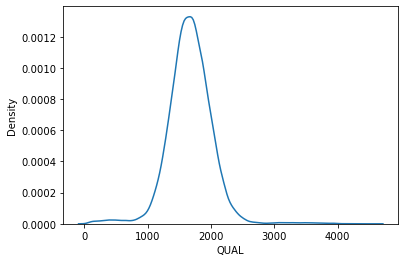

In [245]:
# Plot with seaborn
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(x="QUAL", data=df_qual)

#### <span style="color: #4CACBC;">Plotting Mean depth per site<a class="anchor" id="depthplot"></a></span> 

In [246]:
depth_file="depths.ldepth.mean"
df_depth = pd.read_csv(depth_file, index_col=False, sep="\t")
print(df_depth)
df_depth.describe()

           CHROM     POS  MEAN_DEPTH  VAR_DEPTH
0      Reference      39         4.0        2.0
1      Reference      69         8.0        2.0
2      Reference     103        13.0        8.0
3      Reference     129        18.5        0.5
4      Reference     163        23.0        2.0
...          ...     ...         ...        ...
27453  Reference  999942        12.0       32.0
27454  Reference  999953        10.5       24.5
27455  Reference  999962         8.5        4.5
27456  Reference  999976         6.0        2.0
27457  Reference  999978         6.0        2.0

[27458 rows x 4 columns]


,POS,MEAN_DEPTH,VAR_DEPTH
count,27458.000000,27458.000000,27458.000000
mean,510516.403999,37.772234,36.273545
std,296874.707572,5.131987,53.378846
min,39.000000,1.500000,0.000000
25%,232195.500000,35.500000,4.500000
50%,536109.500000,38.000000,18.000000
75%,766525.000000,41.000000,50.000000
max,999978.000000,56.500000,648.000000


<AxesSubplot:xlabel='MEAN_DEPTH', ylabel='Density'>

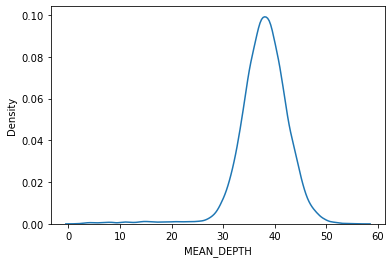

In [247]:
# Plot with seaborn
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(x="MEAN_DEPTH", data=df_depth)

### <span style="color: #4CACBC;">III - FILTERING VCF <a class="anchor" id="vcffiltering"></a></span> 


In [ ]:
#### _GATK VARIANT FILTRATION_

* DP > 10
* QUAL >200
* Less than 3 SNPs into a window of 10pb
* DP < 20000



* GATK VARIANT FILTRATION
* GATK SELECT VARIANTs
* VCFTOOLS NA
* SNP SIFT HOMOZ
* VCFTOOLS BIALLELLIC

In [ ]:
######## GATK VARIANT FILTRATION

## Cmd : module load bioinfo/gatk/4.1.4.1; 
##       gatk VariantFiltration --java-options "-Xmx45G -Xms45G" -R OglaRS2.ADWL02-allCtgsIRIGIN_TOG5681.dedup8095-NR.fasta     -V ALLVCFs/tmp/ALL.Chr06.F4.GenotypeGVCFS.MQ0.vcf.gz --filter-expression "QUAL<200" --filter-name "LOW_QUAL"    --filter-expression "DP<10" --filter-name "LOW_DP"     --cluster-size 3 --cluster-window-size 10     --filter-expression "DP>20000" --filter-name "HIGH-DP"   -O ALLVCFs/tmp/ALL.Chr06.F4.GenotypeGVCFS.MQ0.gatkVF.filteredIndelSNP.vcf


In [ ]:
#### _GATK SELECT VARIANT_

Select only SNPs

In [ ]:
######## GATK SELECT VARIANTS

## Cmd : module load bioinfo/gatk/4.1.4.1; 
    gatk SelectVariants --java-options "-Xmx45G -Xms45G" -R OglaRS2.ADWL02-allCtgsIRIGIN_TOG5681.dedup8095-NR.fasta     -V ALLVCFs/tmp/ALL.Chr06.F4.GenotypeGVCFS.MQ0.gatkVF.filteredIndelSNP.vcf -select-type SNP   -O ALLVCFs/tmp/ALL.Chr06.F4.GenotypeGVCFS.MQ0.gatkVF.filteredIndelSNP.onlySNP.vcf


In [ ]:
#### _vcftools_

* na 12 samples over 228 samples (5%)

In [ ]:
######## VCFTOOLS NA

## Cmd : module load bioinfo/vcftools/0.1.16; vcftools --vcf ALLVCFs/tmp/ALL.Chr06.F4.GenotypeGVCFS.MQ0.gatkVF.filteredIndelSNP.onlySNP.vcf --max-missing-count 12 --remove-filtered-all --recode --recode-INFO-all  --out ALLVCFs/tmp/ALL.Chr06.F4.GenotypeGVCFS.MQ0.gatkVF.filteredIndelSNP.onlySNP.12na


```

In [ ]:
#### _SNPsift_

* homoz = 222 samples (90%)

In [ ]:
######## SNPSIFT HOMOZYGOUS FILTERS

## Cmd : cat ALLVCFs/tmp/ALL.Chr06.F4.GenotypeGVCFS.MQ0.gatkVF.filteredIndelSNP.onlySNP.12na.recode.vcf | java -jar /usr/local/snpEff-4.3/SnpSift.jar filter " (countHom( )> 222) " > ALLVCFs/tmp/ALL.Chr06.F4.GenotypeGVCFS.MQ0.gatkVF.filteredIndelSNP.onlySNP.12na.recode.222homoz.vcf

In [ ]:
#### _vcftools - include only bi-allelic sites_

In [ ]:
#vcftools --vcf /scratch/tranchant/ALL.Chr2.selectVariant.FILTERED.recode.NA.recode.225.Homoz.vcf --min-alleles 2 --max-alleles 2 --out //scratch/tranchant/ALL.Chr2.selectVariant.FILTERED.recode.NA.recode.225.Homoz.minmaxAllele2 --recode --recode-INFO-all
vcftools --vcf /scratch/tranchant/ALLVCFs/tmp/ALL.Chr02.F4.GenotypeGVCFS.MQ0.gatkSV.onlySNP.filteredPASS.na.225.Homoz.vcf --min-alleles 2 --max-alleles 2 --remove-filtered-all --recode --recode-INFO-all --out /scratch/tranchant/ALLVCFs/tmp/ALL.Chr02.F4.GenotypeGVCFS.MQ0.gatkSV.onlySNP.filteredPASS.na.225.Homoz.biallelic

In [236]:
af_file="AF2.frq"
df_csv_stat = pd.read_csv(af_file, index_col=False, header=0, names=["CHROM","POS","N_ALLELES","N_CHR","ALL1","ALL2"], sep="\t")
df_csv_stat

,CHROM,POS,N_ALLELES,N_CHR,ALL1,ALL2
0,Reference,39,2,4,0.5,0.5
1,Reference,69,2,4,0.5,0.5
2,Reference,103,2,4,0.5,0.5
3,Reference,129,2,4,0.5,0.5
4,Reference,163,2,4,0.5,0.5
...,...,...,...,...,...,...
27320,Reference,999942,2,4,0.5,0.5
27321,Reference,999953,2,4,0.5,0.5
27322,Reference,999962,2,4,0.5,0.5
27323,Reference,999976,2,4,0.5,0.5


#### Basic stats

In [214]:
# Je n'affiche que les valeurs de la colonne "mapped"
print(df_csv_stat[["ALL1", "ALL2"]].describe())

               ALL1          ALL2
count  27325.000000  27325.000000
mean       0.498911      0.501089
std        0.025954      0.025954
min        0.000000      0.250000
25%        0.500000      0.500000
50%        0.500000      0.500000
75%        0.500000      0.500000
max        0.750000      1.000000


#### Calculate MAF


In [202]:
df_csv_stat["MAF"]=df_csv_stat[['ALL1', 'ALL2']].min(axis=1)


           CHROM     POS  N_ALLELES  N_CHR  ALL1  ALL2  MAF
326    Reference   10618          2      4   0.0   1.0  0.0
722    Reference   23709          2      4   0.0   1.0  0.0
890    Reference   29167          2      4   0.0   1.0  0.0
1183   Reference   38809          2      4   0.0   1.0  0.0
2066   Reference   68782          2      4   0.0   1.0  0.0
...          ...     ...        ...    ...   ...   ...  ...
25628  Reference  941897          2      4   0.0   1.0  0.0
25943  Reference  952566          2      4   0.0   1.0  0.0
26286  Reference  964815          2      4   0.0   1.0  0.0
27081  Reference  991956          2      4   0.0   1.0  0.0
27171  Reference  995370          2      4   0.0   1.0  0.0

[69 rows x 7 columns]


In [205]:
print(df_csv_stat[df_csv_stat.ALL1>0.70])

          CHROM     POS  N_ALLELES  N_CHR  ALL1  ALL2   MAF
9949  Reference  411494          2      4  0.75  0.25  0.25
9951  Reference  411540          2      4  0.75  0.25  0.25
9952  Reference  411554          2      4  0.75  0.25  0.25
9953  Reference  411628          2      4  0.75  0.25  0.25
9954  Reference  411642          2      4  0.75  0.25  0.25
9955  Reference  411660          2      4  0.75  0.25  0.25
9956  Reference  411667          2      4  0.75  0.25  0.25
9957  Reference  411689          2      4  0.75  0.25  0.25
9958  Reference  411692          2      4  0.75  0.25  0.25
9960  Reference  411775          2      4  0.75  0.25  0.25
9961  Reference  411794          2      4  0.75  0.25  0.25
9962  Reference  411796          2      4  0.75  0.25  0.25
9963  Reference  411806          2      4  0.75  0.25  0.25
9964  Reference  411832          2      4  0.75  0.25  0.25
9965  Reference  411836          2      4  0.75  0.25  0.25
9966  Reference  411861          2      

<AxesSubplot:xlabel='MAF', ylabel='Density'>

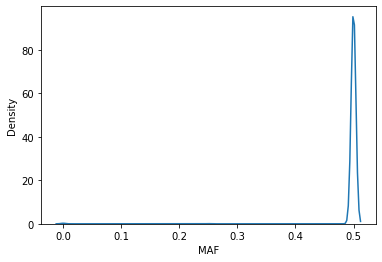

In [211]:
# Plot with seaborn
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(x="MAF", data=df_csv_stat)

In [119]:
cd $vcf_dir

/home/jovyan/work/MAPPING-ILL/VCF


In [ ]:
%%bash
wget --no-check-certificat https://itrop.ird.fr/sv-training/out.vcf.gz

In [124]:
ls

out.vcf.gz


In [128]:
%%bash
zgrep -vc "^#" out.vcf.gz | head

119202


In [141]:
%%bash
REF="/home/jovyan/work/DATA/Clone10/referenceCorrect.fasta"
cd /home/jovyan/work/MAPPING-ILL/VCF/
#tail -n 50 /home/jovyan/work/MAPPING-ILL/VCF/Clone1.g.vcf
gatk CombineGVCFs -R $REF --variant Clone1.g.vcf --variant Clone2.g.vcf  -O final.vcf

Using GATK jar /opt/conda/share/gatk4-4.2.6.1-1/gatk-package-4.2.6.1-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /opt/conda/share/gatk4-4.2.6.1-1/gatk-package-4.2.6.1-local.jar CombineGVCFs -R /home/jovyan/work/DATA/Clone10/referenceCorrect.fasta --variant Clone1.g.vcf --variant Clone2.g.vcf -O final.vcf
19:52:19.329 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/opt/conda/share/gatk4-4.2.6.1-1/gatk-package-4.2.6.1-local.jar!/com/intel/gkl/native/libgkl_compression.so
19:52:19.487 INFO  CombineGVCFs - ------------------------------------------------------------
19:52:19.488 INFO  CombineGVCFs - The Genome Analysis Toolkit (GATK) v4.2.6.1
19:52:19.488 INFO  CombineGVCFs - For support and documentation go to https://software.broadinstitute.org/gatk/
19:52:19.596 INFO  CombineGVCFs - Initializing engine
19:52:19.776 INFO 

In [146]:
%%bash

REF="/home/jovyan/work/DATA/Clone10/referenceCorrect.fasta"
cd /home/jovyan/work/MAPPING-ILL/VCF/
ls -lrt
head -n 1000 final.vcf | tail

gatk --java-options "-Xmx4g" GenotypeGVCFs -R $REF -V final.vcf -O final.genotype.vcf

total 41484
-rw-r--r-- 1 jovyan users  1678691 Jun 16 11:52 out.vcf.gz
-rw-r--r-- 1 jovyan users    22402 Jun 16 19:38 Clone1.g.vcf.idx
-rw-r--r-- 1 jovyan users  8267523 Jun 16 19:38 Clone1.g.vcf
-rw-r--r-- 1 jovyan users 10812528 Jun 16 19:51 Clone2.g.vcf
-rw-r--r-- 1 jovyan users    26799 Jun 16 19:51 Clone2.g.vcf.idx
-rw-r--r-- 1 jovyan users 21611979 Jun 16 19:52 final.vcf
-rw-r--r-- 1 jovyan users    46372 Jun 16 19:52 final.vcf.idx
Reference	4830	.	T	<NON_REF>	.	.	.	GT:DP:GQ:MIN_DP:PL	./.:42:88:42:0,88,1645	./.:45:99:41:0,114,1710
Reference	4831	.	A	<NON_REF>	.	.	END=4874	GT:DP:GQ:MIN_DP:PL	./.:42:99:37:0,105,1575	./.:45:99:41:0,114,1710
Reference	4875	.	T	C,<NON_REF>	.	.	DP=80;ExcessHet=0.00;RAW_MQandDP=140400,39	GT:AD:DP:GQ:MIN_DP:PL:SB	./.:0,38,0:38:99:.:1540,114,0,1540,114,1540:0,0,11,27	./.:.:45:99:41:0,114,1710,114,1710,1710
Reference	4876	.	T	<NON_REF>	.	.	END=4888	GT:DP:GQ:MIN_DP:PL	./.:39:99:38:0,105,1560	./.:45:99:41:0,114,1710
Reference	4889	.	C	A,<NON_REF>	.	.	DP=82;

Using GATK jar /opt/conda/share/gatk4-4.2.6.1-1/gatk-package-4.2.6.1-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -Xmx4g -jar /opt/conda/share/gatk4-4.2.6.1-1/gatk-package-4.2.6.1-local.jar GenotypeGVCFs -R /home/jovyan/work/DATA/Clone10/referenceCorrect.fasta -V final.vcf -O final.genotype.vcf
19:55:48.707 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/opt/conda/share/gatk4-4.2.6.1-1/gatk-package-4.2.6.1-local.jar!/com/intel/gkl/native/libgkl_compression.so
19:55:52.884 INFO  GenotypeGVCFs - ------------------------------------------------------------
19:55:52.884 INFO  GenotypeGVCFs - The Genome Analysis Toolkit (GATK) v4.2.6.1
19:55:52.884 INFO  GenotypeGVCFs - For support and documentation go to https://software.broadinstitute.org/gatk/
19:55:52.890 INFO  GenotypeGVCFs - Initializing engine
19:55:53.079 INFO  FeatureMana

In [155]:
%%bash

REF="/home/jovyan/work/DATA/Clone10/referenceCorrect.fasta"
cd /home/jovyan/work/MAPPING-ILL/VCF/
ls -lrt
head -n 1000 final.genotype.vcf | tail


total 47252
-rw-r--r-- 1 jovyan users  1678691 Jun 16 11:52 out.vcf.gz
-rw-r--r-- 1 jovyan users    22402 Jun 16 19:38 Clone1.g.vcf.idx
-rw-r--r-- 1 jovyan users  8267523 Jun 16 19:38 Clone1.g.vcf
-rw-r--r-- 1 jovyan users 10812528 Jun 16 19:51 Clone2.g.vcf
-rw-r--r-- 1 jovyan users    26799 Jun 16 19:51 Clone2.g.vcf.idx
-rw-r--r-- 1 jovyan users 21611979 Jun 16 19:52 final.vcf
-rw-r--r-- 1 jovyan users    46372 Jun 16 19:52 final.vcf.idx
-rw-r--r-- 1 jovyan users  5896437 Jun 16 19:56 final.genotype.vcf
-rw-r--r-- 1 jovyan users     4301 Jun 16 19:56 final.genotype.vcf.idx
Reference	31207	.	A	T	1532.48	.	AC=2;AF=0.500;AN=4;DP=82;ExcessHet=0.0000;FS=0.000;MLEAC=2;MLEAF=0.500;MQ=60.00;QD=31.37;SOR=0.746	GT:AD:DP:GQ:PL	1/1:0,37:37:99:1548,111,0	0/0:44,0:44:99:0,120,1800
Reference	31219	.	C	G	1802.48	.	AC=2;AF=0.500;AN=4;DP=82;ExcessHet=0.0000;FS=0.000;MLEAC=2;MLEAF=0.500;MQ=60.00;QD=27.75;SOR=0.929	GT:AD:DP:GQ:PL	0/0:36,0:36:99:0,102,1530	1/1:0,45:45:99:1818,135,0
Reference	31223	.	A	G	1

In [159]:
%%bash

REF="/home/jovyan/work/DATA/Clone10/referenceCorrect.fasta"
VCF=home/jovyan/work/MAPPING-ILL/VCF/final.genotype.vcf
cd /home/jovyan/work/MAPPING-ILL/VCF/f
grep  -vc "^#" /

bcftools stats /home/jovyan/work/MAPPING-ILL/VCF/final.genotype.vcf | head -n 50

bash: line 3: cd: /home/jovyan/work/MAPPING-ILL/VCF/f: No such file or directory


27458
# This file was produced by bcftools stats (1.10.2+htslib-1.10.2-3) and can be plotted using plot-vcfstats.
# The command line was:	bcftools stats  /home/jovyan/work/MAPPING-ILL/VCF/final.genotype.vcf
#
# Definition of sets:
# ID	[2]id	[3]tab-separated file names
ID	0	/home/jovyan/work/MAPPING-ILL/VCF/final.genotype.vcf
# SN, Summary numbers:
#   number of records   .. number of data rows in the VCF
#   number of no-ALTs   .. reference-only sites, ALT is either "." or identical to REF
#   number of SNPs      .. number of rows with a SNP
#   number of MNPs      .. number of rows with a MNP, such as CC>TT
#   number of indels    .. number of rows with an indel
#   number of others    .. number of rows with other type, for example a symbolic allele or
#                          a complex substitution, such as ACT>TCGA
#   number of multiallelic sites     .. number of rows with multiple alternate alleles
#   number of multiallelic SNP sites .. number of rows with multiple alternate a

In [ ]:
eles, --freq would return their identity. We need to add max-alleles 2 to exclude sites that have more than two alleles.

vcftools --gzvcf $SUBSET_VCF --freq2 --out $OUT --max-alleles 2

In [ ]:
grep -vc "^#" out.vcf.gz